## Evaluate NMF, SSNMF and Oramas on TBX11K

In [ ]:
# Check Python Version
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)
from tqdm import tqdm

In [32]:
# CUDA
cuda = True
import visualization_util as vis

In [3]:
# Standard imports
import torch, math, time
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
import glob
import PIL
import numpy as np
import skimage, skimage.transform
from skimage.transform import resize
from skimage import util 
import os, time
from matplotlib import pyplot as plt
%matplotlib inline
from numpy import linalg as LA

import os
from os import listdir
from os.path import isfile, join

# SVM eval
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

import ssnmf
from ssnmf import SSNMF


import random
SEED = 10

from tqdm import trange

from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import mpu

import seaborn as sns
from sklearn import metrics

import cv2

from fnnls import fnnls

from scipy import ndimage


torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)


In [4]:
# helper functions
def test_model(A, test_features, K):
    test_n = test_features.shape[1]
    S_test = np.zeros([K, test_n])
    for i in range(test_n):
        #     print("nnls(A_train,test_features[:,i])[0] ", nnls(A_train,test_features[:,i])[0].shape)
        S_test[:, i] = fnnls(A, test_features[:, i])[0]
    return S_test

# Image resize
def imresize(img, height=None, width=None):
    # load image
    if height is not None and width is not None:
        ny = height
        nx = width
    elif height is not None:
        ny = height
        nx = img.shape[1] * ny / img.shape[0]
    elif width is not None:
        nx = width
        ny = img.shape[0] * nx / img.shape[1]
    else:
        ny = img.shape[0]
        nx = img.shape[1]

    return skimage.transform.resize(img, (int(ny), int(nx)), mode='constant')

## Load in Data

In [5]:
# TIP: make sure there is a directory DATA (in our case data/) 
# that contains TBX11K training data (TBX11K_classification_splits_sub)

In [6]:
# load tbx 11k
data_dir = 'data/TBX11K_classification_splits_sub/'

files = [f for f in glob.glob(data_dir+"/*/*/*")]
print(files[0:10])
class_dict = {
    "health": 0,
    "sick": 1,
    "tb": 2
}

split_dict = {
    "train": 0,
    "val": 1,
    "test": 2
}

['data/TBX11K_classification_splits_sub/train/sick/s4132.png', 'data/TBX11K_classification_splits_sub/train/sick/s2747.png', 'data/TBX11K_classification_splits_sub/train/sick/s0568.png', 'data/TBX11K_classification_splits_sub/train/sick/s3332.png', 'data/TBX11K_classification_splits_sub/train/sick/s3482.png', 'data/TBX11K_classification_splits_sub/train/sick/s2515.png', 'data/TBX11K_classification_splits_sub/train/sick/s2809.png', 'data/TBX11K_classification_splits_sub/train/sick/s2224.png', 'data/TBX11K_classification_splits_sub/train/sick/s0203.png', 'data/TBX11K_classification_splits_sub/train/sick/s4582.png']


In [7]:
img_path = files[0]
print(img_path[:-4].split('/')[-3])

train


In [9]:
# # DEBUG: subset
# random.shuffle(files)
# files = files[0:100]

images = []
labels = []
splits = []
for img_path in tqdm(files):
    if((img_path[-4:] in ".png") and (img_path[:-4].split('/')[-2] in class_dict.keys())):
    
        img = plt.imread(img_path) 
        if len(img.shape)>2:
            img = img[:,:,0]
        
        img1 = imresize(img,256,256)
        images.append(img1)
        
        # save class
        class_string = img_path[:-4].split('/')[-2]
        labels.append(class_dict[class_string])
        
        # split (train, val, test)
        split_string = img_path[:-4].split('/')[-3]
        # print(split_string + " " + str(split_dict[split_string]))
        splits.append(split_dict[split_string])

print(len(images))

100%|█████████████████████████████████████████████████████████████████████████████████████| 2472/2472 [00:50<00:00, 48.84it/s]

2472


## Perform Data Pre-Processing

In [10]:
train_data = []
val_data = []
train_labels = []
val_labels = []

train_ind = [i for i in range(len(splits)) if splits[i]==0]
test_ind = [i for i in range(len(splits)) if splits[i]==2]

for i in train_ind:
    train_data.extend([images[i]])
    train_labels.extend([labels[i]])

for i in test_ind: # test -> val (notation change)
    val_data.extend([images[i]])
    val_labels.extend([labels[i]])
    
filenames = [files[i] for i in train_ind] + [files[i] for i in test_ind]

In [11]:
print(len(train_ind))
print(len(test_ind))

824
824


In [12]:
# plt.hist(labels)

In [13]:
# One-hot encoding
classes = 1 + max([max(val_labels), max(train_labels)])

# Train set
y_img_train = np.zeros((len(train_data),classes,14,14))
for i in range(len(train_data)):
    y_img_train[i,train_labels[i],:,:] = 1

# Test set
y_img_val = np.zeros((len(val_data),classes,14,14))
for i in range(len(val_data)):
    y_img_val[i,val_labels[i],:,:] = 1

In [14]:
NCHANNELS = 1

# ADD COLOR CHANNEL DATA
data = train_data + val_data # merge train and test
new_data = []
new_data.extend(data[i] for i in range(len(data)) for j in range(NCHANNELS))
len(new_data)

1648

In [15]:
new_images = np.array(new_data).reshape((len(data), NCHANNELS, 256, 256))
print(new_images.shape)

(1648, 1, 256, 256)


In [16]:
my_transform = transforms.Compose([
        #transforms.Resize(224),
        transforms.Normalize(0., 1.)])

In [17]:
# RESIZE
raw_images = resize(new_images, (new_images.shape[0],NCHANNELS,224,224))
# raw_images = 1.0-raw_images
# Pre-process
images = raw_images.transpose((0,1,2,3)).astype('float32') # to numpy, NxCxHxW, float32
if NCHANNELS == 3:
    images -= np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)) # zero mean
    images /= np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)) # unit variance
    images = torch.from_numpy(images) # convert to Pytorch tensor
else:
    images_new = torch.zeros(images.shape)
    for i in tqdm(range(len(images))):
        transformed_img = my_transform(torch.Tensor(images[0]))

        images_new[i] = transformed_img

    images = images_new
if cuda:
    images = images.cuda()
    
print(images.shape)

100%|███████████████████████████████████████████████████████████████████████████████████| 1648/1648 [00:00<00:00, 7835.83it/s]


torch.Size([1648, 1, 224, 224])


In [18]:
np.unique(raw_images)

array([0.0000000e+00, 3.4826322e-13, 6.9652644e-13, ..., 9.9999988e-01,
       9.9999994e-01, 1.0000000e+00], dtype=float32)

In [20]:
TRAIN_IMG_IDS = np.arange(0, len(train_data))
TEST_IMG_IDS = np.arange(len(train_data), len(data))

print(len(TRAIN_IMG_IDS))
print(len(TEST_IMG_IDS))

824
824


In [21]:
# combine train and test data (optional)
# TRAIN_IMG_IDS = np.append(TRAIN_IMG_IDS,TEST_IMG_IDS)
# y_img_train = np.append(y_img_train,y_img_val, axis=0)

## Use Standard Pre-trained Model to Generate Features

In [22]:
print(NCHANNELS)

1


In [23]:
from timm import create_model
net = create_model('vgg16', pretrained=True, in_chans=NCHANNELS, num_classes=classes) #, num_classes=num_classes)

# load pre-trained model
CHECK_POINT_PATH = 'tbx11k_vgg16.pth'
checkpoint = torch.load(CHECK_POINT_PATH)
net.load_state_dict(checkpoint['model_state_dict']) 

if cuda:
    net = net.cuda()
    
del net.features._modules['30'] # remove max-pooling after final conv layer
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
def process_large(IMG_IDS):
    features0 = []
    step = 10
    for i in tqdm(range(0, len(IMG_IDS), step)):
        x = i
        features_sub = net.features(images[TRAIN_IMG_IDS[x:x+step]])
        features0.append(features_sub.cpu().detach().numpy())
    features = np.concatenate(features0, axis=0)
    return features

In [25]:
PROCESS_LARGE_DATASET = len(TRAIN_IMG_IDS) > 200 or len(TEST_IMG_IDS) > 200
if PROCESS_LARGE_DATASET:
    features_train_np = process_large(TRAIN_IMG_IDS)
    features_test_np = process_large(TEST_IMG_IDS)

    features_train = torch.Tensor(features_train_np).cuda() # very inefficient, but to maintain code flow
    flat_features_train = features_train.permute(0, 2, 3, 1).contiguous().view((-1, features_train.size(1))) # NxCxHxW -> (N*H*W)xC

    features_test = torch.Tensor(features_test_np).cuda() # very inefficient, but to maintain code flow
    flat_features_test = features_test.permute(0, 2, 3, 1).contiguous().view((-1, features_test.size(1))) # NxCxHxW -> (N*H*W)xC


else:
    with torch.no_grad():
        features_train = net.features(images[TRAIN_IMG_IDS])
        flat_features_train = features_train.permute(0, 2, 3, 1).contiguous().view((-1, features_train.size(1))) # NxCxHxW -> (N*H*W)xC

    with torch.no_grad():
        features_test = net.features(images[TEST_IMG_IDS])
        flat_features_test = features_test.permute(0, 2, 3, 1).contiguous().view((-1, features_test.size(1))) # NxCxHxW -> (N*H*W)xC

y_train = np.transpose(y_img_train, (0, 2, 3, 1))
y_train = np.reshape(y_train, (-1,y_img_train.shape[1]))

y_test = np.transpose(y_img_val, (0, 2, 3, 1))
y_test = np.reshape(y_test, (-1,y_img_val.shape[1]))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.86it/s]


In [26]:
print(classes)

3


In [27]:
# DEBUG
features_train_backup_np = features_train.clone().cpu().numpy()

# Run NMF and SSNMF

In [28]:
def run_nmf(K,modelNum,flat_features_train,flat_features_test):
    model_nmf = SSNMF(flat_features_train.cpu().numpy().T,
                 K,
                 modelNum=modelNum)

    model_nmf.mult(numiters = 10000)


    # Visualize Training
    S_train = model_nmf.S
    W_np = model_nmf.S.T
    heatmaps_np = np.transpose(W_np.reshape(features_train.size(0), features_train.size(2), features_train.size(3), K),(0,3,1,2)) #.permute(0,3,1,2) # (N*H*W)xK -> NxKxHxW
    heatmaps_resized_np = np.zeros((heatmaps_np.shape[0],heatmaps_np.shape[1],224,224))
    for id0 in range(heatmaps_np.shape[0]):
        for id1 in range(heatmaps_np.shape[1]):
            heatmaps_resized_np[id0,id1,:,:] = cv2.resize(heatmaps_np[id0,id1,:,:], (224, 224),interpolation=cv2.INTER_LINEAR)
    tmp1 = np.amax(np.reshape(heatmaps_resized_np,(heatmaps_resized_np.shape[0],heatmaps_resized_np.shape[1]*heatmaps_resized_np.shape[2]*heatmaps_resized_np.shape[3])), axis=1)

    for id0 in range(heatmaps_resized_np.shape[0]):
          heatmaps_resized_np[id0] = heatmaps_resized_np[id0]/tmp1[id0]
            
    heatmaps_nmf_train_resized_np = np.array(heatmaps_resized_np, copy=True)

    S_test = test_model(model_nmf.A, flat_features_test.cpu().numpy().T , K)
    # Visualize Testing
    W_np = S_test.T
    heatmaps_np = np.transpose(W_np.reshape(features_test.size(0), features_test.size(2), features_test.size(3), K),(0,3,1,2)) #.permute(0,3,1,2) # (N*H*W)xK -> NxKxHxW
    heatmaps_resized_np = np.zeros((heatmaps_np.shape[0],heatmaps_np.shape[1],224,224))
    for id in range(heatmaps_np.shape[0]):
        for id1 in range(heatmaps_np.shape[1]):
            heatmaps_resized_np[id,id1,:,:] = cv2.resize(heatmaps_np[id,id1,:,:], (224, 224),interpolation=cv2.INTER_LINEAR)
    tmp1 = np.amax(np.reshape(heatmaps_resized_np,(heatmaps_resized_np.shape[0],heatmaps_resized_np.shape[1]*heatmaps_resized_np.shape[2]*heatmaps_resized_np.shape[3])), axis=1)

    for id in range(heatmaps_resized_np.shape[0]):
        heatmaps_resized_np[id] = heatmaps_resized_np[id]/tmp1[id]

    heatmaps_nmf_test_resized_np = np.array(heatmaps_resized_np,copy=True)
    return heatmaps_nmf_train_resized_np,heatmaps_nmf_test_resized_np


def run_ssnmf(K,modelNum,MULT,flat_features_train,train_labels,flat_features_test,val_labels):
    model_ssnmf = SSNMF(flat_features_train.cpu().numpy().T,
                 K,
                 Y=y_train.T, 
                 lam = MULT*np.linalg.norm(flat_features_train.cpu().numpy().T,'fro')**2, 
                 modelNum=modelNum)

    model_ssnmf.mult(numiters = 10000)

    # Visualize Training
    S_train = model_ssnmf.S
    W_np = model_ssnmf.S.T
    heatmaps_np = np.transpose(W_np.reshape(features_train.size(0), features_train.size(2), features_train.size(3), K),(0,3,1,2)) #.permute(0,3,1,2) # (N*H*W)xK -> NxKxHxW
    heatmaps_resized_np = np.zeros((heatmaps_np.shape[0],heatmaps_np.shape[1],224,224))
    for id0 in range(heatmaps_np.shape[0]):
        for id1 in range(heatmaps_np.shape[1]):
            heatmaps_resized_np[id0,id1,:,:] = cv2.resize(heatmaps_np[id0,id1,:,:], (224, 224),interpolation=cv2.INTER_LINEAR)
    tmp1 = np.amax(np.reshape(heatmaps_resized_np,(heatmaps_resized_np.shape[0],heatmaps_resized_np.shape[1]*heatmaps_resized_np.shape[2]*heatmaps_resized_np.shape[3])), axis=1)

    for id0 in range(heatmaps_resized_np.shape[0]):
          heatmaps_resized_np[id0] = heatmaps_resized_np[id0]/tmp1[id0]
            
    heatmaps_ssnmf_train_resized_np = np.array(heatmaps_resized_np, copy=True)

    S_test = test_model(model_ssnmf.A, flat_features_test.cpu().numpy().T , K)
    # Visualize Testing
    W_np = S_test.T
    heatmaps_np = np.transpose(W_np.reshape(features_test.size(0), features_test.size(2), features_test.size(3), K),(0,3,1,2)) #.permute(0,3,1,2) # (N*H*W)xK -> NxKxHxW
    heatmaps_resized_np = np.zeros((heatmaps_np.shape[0],heatmaps_np.shape[1],224,224))
    for id in range(heatmaps_np.shape[0]):
        for id1 in range(heatmaps_np.shape[1]):
            heatmaps_resized_np[id,id1,:,:] = cv2.resize(heatmaps_np[id,id1,:,:], (224, 224),interpolation=cv2.INTER_LINEAR)
    tmp1 = np.amax(np.reshape(heatmaps_resized_np,(heatmaps_resized_np.shape[0],heatmaps_resized_np.shape[1]*heatmaps_resized_np.shape[2]*heatmaps_resized_np.shape[3])), axis=1)

    for id in range(heatmaps_resized_np.shape[0]):
        heatmaps_resized_np[id] = heatmaps_resized_np[id]/tmp1[id]

    heatmaps_ssnmf_test_resized_np = np.array(heatmaps_resized_np,copy=True)
    return heatmaps_ssnmf_train_resized_np,heatmaps_ssnmf_test_resized_np



In [29]:
K = classes
modelNum=3
heatmaps_ssnmf_train_resized_np,heatmaps_ssnmf_test_resized_np = run_ssnmf(K,modelNum,10e-6,flat_features_train,train_labels,flat_features_test,val_labels)

modelNum=1
heatmaps_nmf_train_resized_np,heatmaps_nmf_test_resized_np = run_nmf(K,modelNum,flat_features_train,flat_features_test)

## Visualizations

In [30]:
raw_images_torch = torch.Tensor(raw_images)
if raw_images_torch.shape[1]==1: # if using 1 channel images, adjust for visualization
    raw_images_torch = raw_images_torch.repeat(1,3,1,1)
raw_images_torch.shape

torch.Size([1648, 3, 224, 224])

label  0


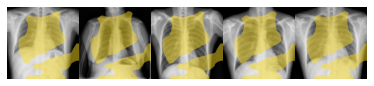

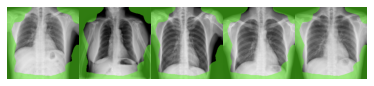

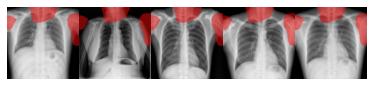

saved to nmf1_TBX11K_train_0.png
label  1


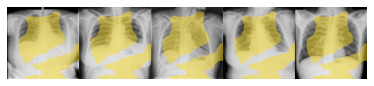

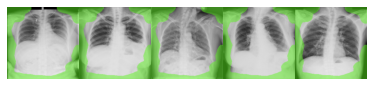

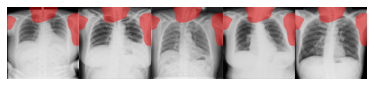

saved to nmf1_TBX11K_train_1.png
label  2


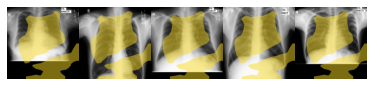

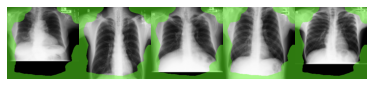

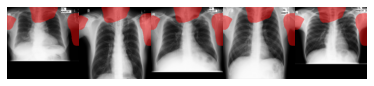

saved to nmf1_TBX11K_train_2.png
saved to nmf1_TBX11K_train_all1.png


In [33]:
MAX_SHOW = 10
return_indices_nmf_train = vis.visualize(raw_images_torch[TRAIN_IMG_IDS], np.array(heatmaps_nmf_train_resized_np,copy=True), 
                              train_labels, MAX_SHOW, save_prefix='nmf1_TBX11K_train_')

label  0


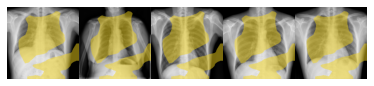

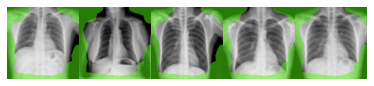

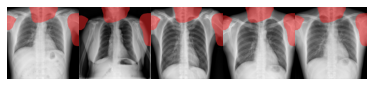

saved to nmf1_TBX11K_test_0.png
label  1


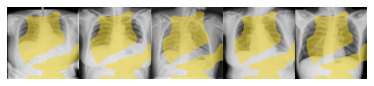

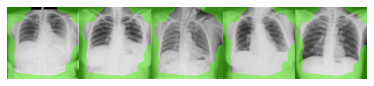

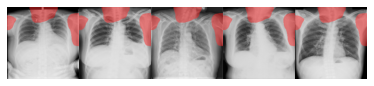

saved to nmf1_TBX11K_test_1.png
label  2


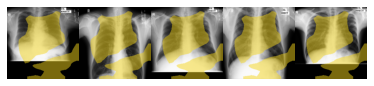

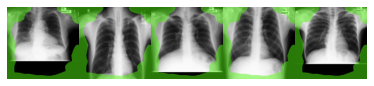

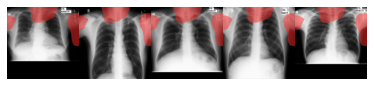

saved to nmf1_TBX11K_test_2.png
saved to nmf1_TBX11K_test_all1.png


In [34]:
return_indices_nmf_test=vis.visualize(raw_images_torch[TEST_IMG_IDS], np.array(heatmaps_nmf_test_resized_np,copy=True), 
                              val_labels, MAX_SHOW, save_prefix='nmf1_TBX11K_test_')

label  0


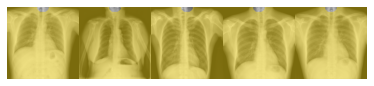

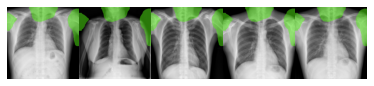

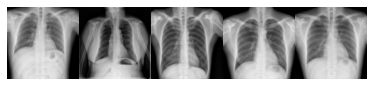

saved to ssnmf1_TBX11K_train_0.png
label  1


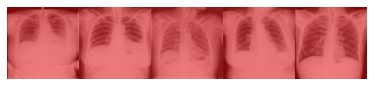

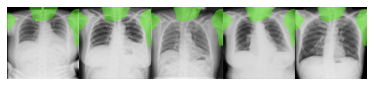

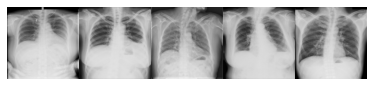

saved to ssnmf1_TBX11K_train_1.png
label  2


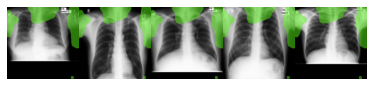

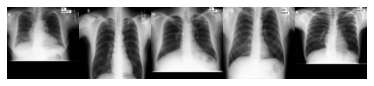

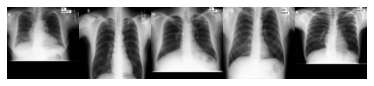

saved to ssnmf1_TBX11K_train_2.png
saved to ssnmf1_TBX11K_train_all1.png


In [35]:
return_indices_ssnmf_train = vis.visualize(raw_images_torch[TRAIN_IMG_IDS], np.array(heatmaps_ssnmf_train_resized_np,copy=True), 
                              train_labels, MAX_SHOW, save_prefix='ssnmf1_TBX11K_train_')

label  0


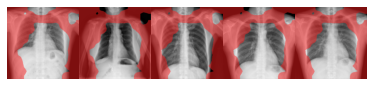

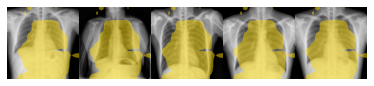

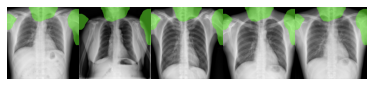

saved to ssnmf1_TBX11K_test_0.png
label  1


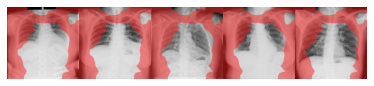

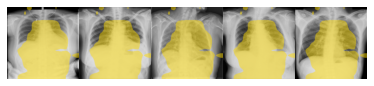

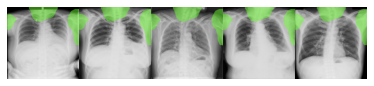

saved to ssnmf1_TBX11K_test_1.png
label  2


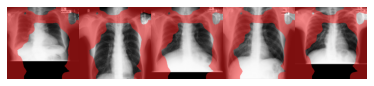

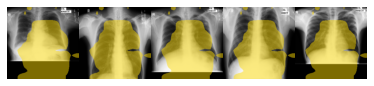

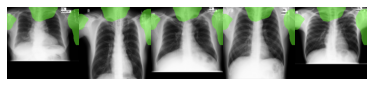

saved to ssnmf1_TBX11K_test_2.png
saved to ssnmf1_TBX11K_test_all1.png


In [36]:
return_indices_ssnmf_test = vis.visualize(raw_images_torch[TEST_IMG_IDS], np.array(heatmaps_ssnmf_test_resized_np,copy=True), 
                              val_labels, MAX_SHOW, save_prefix='ssnmf1_TBX11K_test_')